<a href="https://colab.research.google.com/github/dev3z/Lipophilicity-prediction/blob/main/Lipophilicity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Cell 1: Install Chemprop and dependencies
# Takes ~2-3 min
!pip install chemprop matplotlib pandas numpy scikit-learn

In [25]:
# Cell 2: Download Lipophilicity dataset from DeepChem mirror
# (Avoids MoleculeNet issues; ~200 KB)
import os
!wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv -O lipophilicity_full.csv

# Verify file exists and is non-empty
if os.path.exists('lipophilicity_full.csv') and os.path.getsize('lipophilicity_full.csv') > 1000:
    print("Download successful! File size:", os.path.getsize('lipophilicity_full.csv'), "bytes")
else:
    raise FileNotFoundError("Download failed or file is empty. Check network or URL.")

--2025-11-13 08:46:06--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.216.226, 52.219.193.10, 52.219.112.209, ...
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.216.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 282606 (276K) [text/csv]
Saving to: ‘lipophilicity_full.csv’

lipophilicity_full. 100%[===================>] 275.98K  1.45MB/s    in 0.2s    

2025-11-13 08:46:07 (1.45 MB/s) - ‘lipophilicity_full.csv’ saved [282606/282606]

Download successful! File size: 282606 bytes


In [26]:
# Cell 3: Verify dataset
import pandas as pd
try:
    df = pd.read_csv('lipophilicity_full.csv')
    df = df.rename(columns={'smiles': 'smiles', 'exp': 'exp'})  # Standardize column names
    df = df[['smiles', 'exp']]  # Keep only SMILES and logP
    print(df.head())  # Show first 5 rows
    print(f"Dataset size: {len(df)} rows")  # Should be ~4,200
    df.to_csv('lipophilicity.csv', index=False)  # Save clean version
except pd.errors.EmptyDataError:
    print("Error: lipophilicity_full.csv is empty. Re-download or check URL.")
    raise

                                              smiles   exp
0            Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14  3.54
1  COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)... -1.18
2             COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl  3.69
3  OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...  3.37
4  Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...  3.10
Dataset size: 4200 rows


In [27]:
# Cell 4: Train Chemprop model with internal splitting
# Takes ~10-15 min (faster on GPU)
# Uses --split-type random for 80/10/10 train/val/test
!chemprop train \
    --data-path lipophilicity.csv \
    --task-type regression \
    --output-dir checkpoints \
    --epochs 20 \
    --smiles-columns smiles \
    --split-type random \
    --split-sizes 0.8 0.1 0.1 \
    --data-seed 42  # Reproducible splits

2025-11-13T08:46:22 - INFO:chemprop.cli.main - Running in mode 'train' with args: {'smiles_columns': ['smiles'], 'reaction_columns': None, 'no_header_row': False, 'num_workers': 0, 'batch_size': 64, 'accelerator': 'auto', 'devices': 'auto', 'rxn_mode': 'REAC_DIFF', 'multi_hot_atom_featurizer_mode': 'V2', 'keep_h': False, 'add_h': False, 'ignore_stereo': False, 'reorder_atoms': False, 'molecule_featurizers': None, 'descriptors_path': None, 'descriptors_columns': None, 'no_descriptor_scaling': False, 'no_atom_feature_scaling': False, 'no_atom_descriptor_scaling': False, 'no_bond_feature_scaling': False, 'no_bond_descriptor_scaling': False, 'atom_features_path': None, 'atom_descriptors_path': None, 'bond_features_path': None, 'bond_descriptors_path': None, 'constraints_path': None, 'constraints_to_targets': None, 'use_cuikmolmaker_featurization': False, 'config_path': None, 'data_path': PosixPath('lipophilicity.csv'), 'output_dir': PosixPath('checkpoints'), 'remove_checkpoints': False, 'c

In [28]:
# Cell 5: Create a separate test set for evaluation
# Holds out 10% fresh data
from sklearn.model_selection import train_test_split
full_df = pd.read_csv('lipophilicity.csv')
_, test_df = train_test_split(full_df, test_size=0.1, random_state=42)  # 10% test
test_df.to_csv('test.csv', index=False)
print(f"Test set size: {len(test_df)} rows")
print(test_df.head())

Test set size: 420 rows
                                                 smiles   exp
1743      Clc1ccc2NC(=O)CN(C(c3ccccc3)c2c1)C(=O)c4occc4  3.00
2196             CCCNC[C@H](O)COc1ccccc1C(=O)CCc2ccccc2  1.69
1728  CNc1cccc(CCCc2ccc(C[C@H](NC(=O)c3c(Cl)cccc3Cl)...  0.78
3337                   CC1(C)CNC(=O)c2sc(nc2C1)N3CCOCC3  1.29
298   C[C@@](O)(C(=O)Nc1ccc(cc1Cl)S(=O)(=O)NCC=C)C(F...  3.07


In [29]:
# Cell 6: Predict on test set
!chemprop predict \
    --test-path test.csv \
    --model-paths checkpoints/best.pt \
    --preds-path test_preds.csv \
    --smiles-columns smiles

2025-11-13T08:51:25 - INFO:chemprop.cli.main - Running in mode 'predict' with args: {'smiles_columns': ['smiles'], 'reaction_columns': None, 'no_header_row': False, 'num_workers': 0, 'batch_size': 64, 'accelerator': 'auto', 'devices': 'auto', 'rxn_mode': 'REAC_DIFF', 'multi_hot_atom_featurizer_mode': 'V2', 'keep_h': False, 'add_h': False, 'ignore_stereo': False, 'reorder_atoms': False, 'molecule_featurizers': None, 'descriptors_path': None, 'descriptors_columns': None, 'no_descriptor_scaling': False, 'no_atom_feature_scaling': False, 'no_atom_descriptor_scaling': False, 'no_bond_feature_scaling': False, 'no_bond_descriptor_scaling': False, 'atom_features_path': None, 'atom_descriptors_path': None, 'bond_features_path': None, 'bond_descriptors_path': None, 'constraints_path': None, 'constraints_to_targets': None, 'use_cuikmolmaker_featurization': False, 'test_path': PosixPath('test.csv'), 'output': PosixPath('test_preds.csv'), 'drop_extra_columns': False, 'model_paths': [PosixPath('chec

In [31]:
# Verify model saved
import os
if os.path.exists('checkpoints/model_0/best.pt'):
    print("Training successful! Model saved at checkpoints/model_0/best.pt")
else:
    print("Training failed! Check checkpoints/train.log for errors.")
    # The train.log file might be in a different path or not generated directly.
    # For debugging, we can check the general output of the training step or specific logs if they exist.
    raise FileNotFoundError("Model file checkpoints/model_0/best.pt not found.")

Training successful! Model saved at checkpoints/model_0/best.pt


In [35]:
# Cell 4: Train Chemprop model with debugging
# Use GPU if available; captures output
!chemprop train \
    --data-path lipophilicity.csv \
    --task-type regression \
    --output-dir checkpoints \
    --epochs 20 \
    --smiles-columns smiles \
    --split-type random \
    --split-sizes 0.8 0.1 0.1 \
    --data-seed 42 \
    --quiet false  # Show detailed logs

usage: chemprop [-h] {train,predict,convert,fingerprint,hpopt} ...
chemprop: error: unrecognized arguments: --quiet false


In [36]:
if os.path.exists('checkpoints/model_0/best.pt'):
    print("Training successful! Model saved at checkpoints/model_0/best.pt")
else:
    print("Training failed! Check output above for errors.")
    raise FileNotFoundError("Model file checkpoints/model_0/best.pt not found.")

Training successful! Model saved at checkpoints/model_0/best.pt


In [37]:
# Cell 6: Predict on test set
!chemprop predict \
    --test-path test.csv \
    --model-paths checkpoints/model_0/best.pt \
    --preds-path test_preds.csv \
    --smiles-columns smiles
if not os.path.exists('test_preds.csv'):
    raise FileNotFoundError("test_preds.csv not found.")

2025-11-13T08:58:06 - INFO:chemprop.cli.main - Running in mode 'predict' with args: {'smiles_columns': ['smiles'], 'reaction_columns': None, 'no_header_row': False, 'num_workers': 0, 'batch_size': 64, 'accelerator': 'auto', 'devices': 'auto', 'rxn_mode': 'REAC_DIFF', 'multi_hot_atom_featurizer_mode': 'V2', 'keep_h': False, 'add_h': False, 'ignore_stereo': False, 'reorder_atoms': False, 'molecule_featurizers': None, 'descriptors_path': None, 'descriptors_columns': None, 'no_descriptor_scaling': False, 'no_atom_feature_scaling': False, 'no_atom_descriptor_scaling': False, 'no_bond_feature_scaling': False, 'no_bond_descriptor_scaling': False, 'atom_features_path': None, 'atom_descriptors_path': None, 'bond_features_path': None, 'bond_descriptors_path': None, 'constraints_path': None, 'constraints_to_targets': None, 'use_cuikmolmaker_featurization': False, 'test_path': PosixPath('test.csv'), 'output': PosixPath('test_preds.csv'), 'drop_extra_columns': False, 'model_paths': [PosixPath('chec

In [39]:
# Cell 7: Evaluate test results
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load the true values from the original test.csv
true_df = pd.read_csv('test.csv')
true = true_df['exp']

# Load the predicted values from test_preds.csv
pred_df = pd.read_csv('test_preds.csv')
pred = pred_df['exp'] # The predicted column is also named 'exp' by Chemprop

r2 = r2_score(true, pred)
rmse = np.sqrt(mean_squared_error(true, pred))
mae = mean_absolute_error(true, pred)

print(f"R²: {r2:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}")

R²: 0.711, RMSE: 0.636, MAE: 0.492


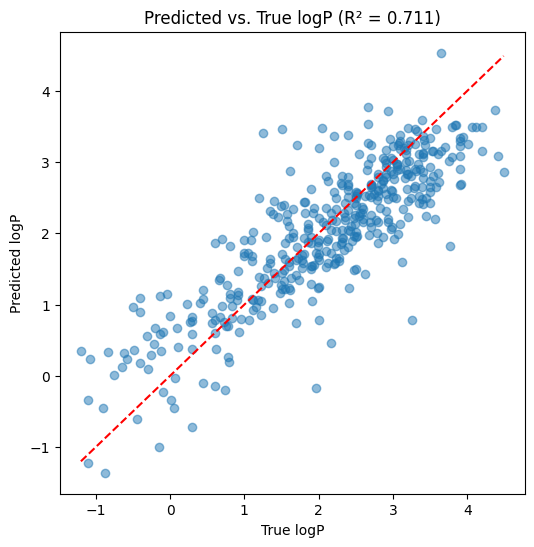

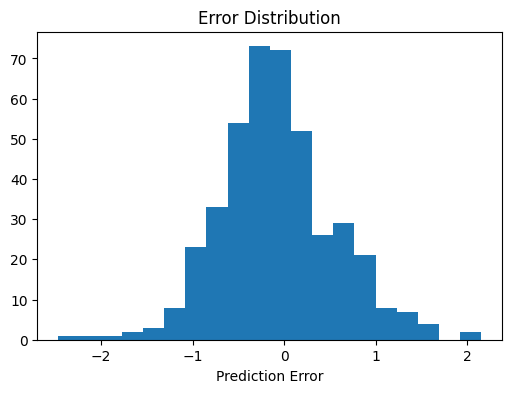

In [40]:
# Cell 8: Visualize results
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.scatter(true, pred, alpha=0.5)
plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--')
plt.xlabel('True logP'); plt.ylabel('Predicted logP')
plt.title(f'Predicted vs. True logP (R² = {r2:.3f})')
plt.savefig('scatter.png')
plt.show()
plt.figure(figsize=(6, 4))
plt.hist(pred - true, bins=20)
plt.xlabel('Prediction Error'); plt.title('Error Distribution')
plt.savefig('histogram.png')
plt.show()

In [43]:
# Cell 9: Predict on new molecules
new_mols = pd.DataFrame({
    'smiles': ['CCO', 'C1CCCCC1C=O', 'c1ccccc1C(=O)O'],
    'exp': [0.50, 1.90, 2.30]
})
new_mols.to_csv('new_mols.csv', index=False)
!chemprop predict \
    --test-path new_mols.csv \
    --model-paths checkpoints/model_0/best.pt \
    --preds-path new_preds.csv \
    --smiles-columns smiles

# Ensure the prediction file was created before attempting to read it
if os.path.exists('new_preds.csv'):
    new_preds = pd.read_csv('new_preds.csv')
    # Chemprop uses 'exp' as the predicted column name if the target column is 'exp'
    new_preds = pd.concat([new_mols['smiles'], new_preds['exp']], axis=1)
    new_preds = new_preds.rename(columns={'exp': 'exp_pred'})
    print("New Molecule Predictions:")
    print(new_preds)
else:
    raise FileNotFoundError("Prediction file 'new_preds.csv' not found. Check chemprop predict output for errors.")

2025-11-13T09:00:58 - INFO:chemprop.cli.main - Running in mode 'predict' with args: {'smiles_columns': ['smiles'], 'reaction_columns': None, 'no_header_row': False, 'num_workers': 0, 'batch_size': 64, 'accelerator': 'auto', 'devices': 'auto', 'rxn_mode': 'REAC_DIFF', 'multi_hot_atom_featurizer_mode': 'V2', 'keep_h': False, 'add_h': False, 'ignore_stereo': False, 'reorder_atoms': False, 'molecule_featurizers': None, 'descriptors_path': None, 'descriptors_columns': None, 'no_descriptor_scaling': False, 'no_atom_feature_scaling': False, 'no_atom_descriptor_scaling': False, 'no_bond_feature_scaling': False, 'no_bond_descriptor_scaling': False, 'atom_features_path': None, 'atom_descriptors_path': None, 'bond_features_path': None, 'bond_descriptors_path': None, 'constraints_path': None, 'constraints_to_targets': None, 'use_cuikmolmaker_featurization': False, 'test_path': PosixPath('new_mols.csv'), 'output': PosixPath('new_preds.csv'), 'drop_extra_columns': False, 'model_paths': [PosixPath('c

In [45]:
# Cell 9: Predict on new molecules
new_mols = pd.DataFrame({
    'smiles': ['CCO', 'C1CC1C=O', 'c1ccc1C(=O)O'],
    'exp': [0.50, 1.90, 2.30]
})
new_mols.to_csv('new_mols.csv', index=False)
!chemprop predict \
    --test-path new_mols.csv \
    --model-paths checkpoints/model_0/best.pt \
    --preds-path new_preds.csv \
    --smiles-columns smiles

# Ensure the prediction file was created before attempting to read it
if os.path.exists('new_preds.csv'):
    new_preds = pd.read_csv('new_preds.csv')
    # Chemprop uses 'exp' as the predicted column name if the target column is 'exp'
    new_preds = pd.concat([new_mols['smiles'], new_preds['exp']], axis=1)
    new_preds = new_preds.rename(columns={'exp': 'exp_pred'})
    print("New Molecule Predictions:")
    print(new_preds)
else:
    raise FileNotFoundError("Prediction file 'new_preds.csv' not found. Check chemprop predict output for errors.")

2025-11-13T09:02:47 - INFO:chemprop.cli.main - Running in mode 'predict' with args: {'smiles_columns': ['smiles'], 'reaction_columns': None, 'no_header_row': False, 'num_workers': 0, 'batch_size': 64, 'accelerator': 'auto', 'devices': 'auto', 'rxn_mode': 'REAC_DIFF', 'multi_hot_atom_featurizer_mode': 'V2', 'keep_h': False, 'add_h': False, 'ignore_stereo': False, 'reorder_atoms': False, 'molecule_featurizers': None, 'descriptors_path': None, 'descriptors_columns': None, 'no_descriptor_scaling': False, 'no_atom_feature_scaling': False, 'no_atom_descriptor_scaling': False, 'no_bond_feature_scaling': False, 'no_bond_descriptor_scaling': False, 'atom_features_path': None, 'atom_descriptors_path': None, 'bond_features_path': None, 'bond_descriptors_path': None, 'constraints_path': None, 'constraints_to_targets': None, 'use_cuikmolmaker_featurization': False, 'test_path': PosixPath('new_mols.csv'), 'output': PosixPath('new_preds.csv'), 'drop_extra_columns': False, 'model_paths': [PosixPath('c

In [46]:
# Cell 10: Download files
from google.colab import files
files.download('scatter.png')
files.download('histogram.png')
files.download('test_preds.csv')
files.download('new_preds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

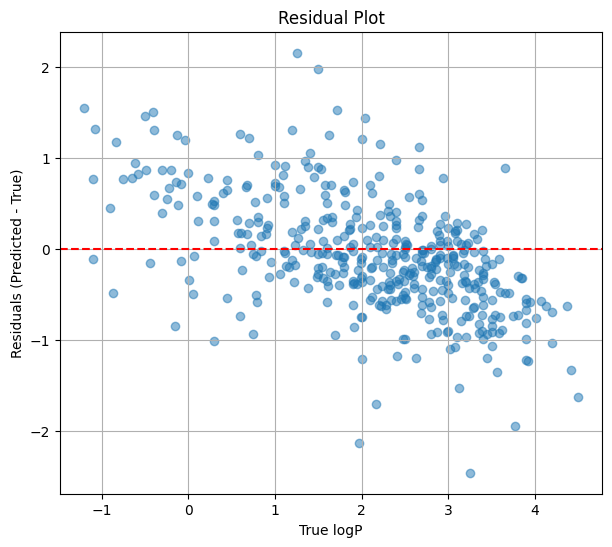

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residual Plot
plt.figure(figsize=(7, 6))
residuals = pred - true
plt.scatter(true, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True logP')
plt.ylabel('Residuals (Predicted - True)')
plt.title('Residual Plot')
plt.grid(True)
plt.savefig('residual_plot.png')
plt.show()

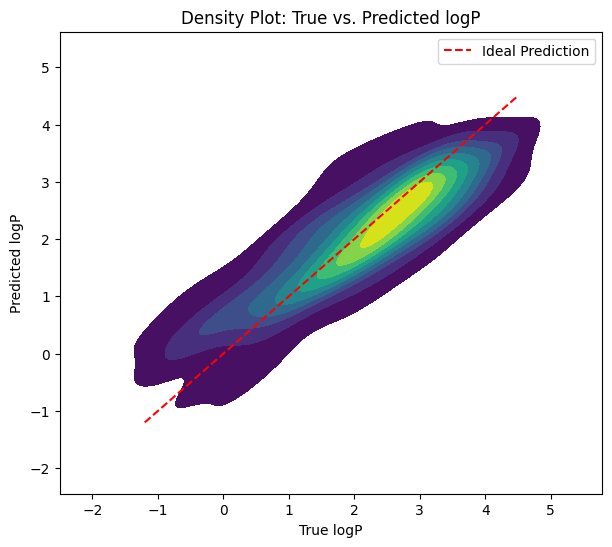

In [48]:
# Density Plot (Kernel Density Estimate) for True vs. Predicted
plt.figure(figsize=(7, 6))
sns.kdeplot(x=true, y=pred, fill=True, cmap="viridis", levels=10)
plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--', label='Ideal Prediction')
plt.xlabel('True logP')
plt.ylabel('Predicted logP')
plt.title('Density Plot: True vs. Predicted logP')
plt.legend()
plt.savefig('density_plot.png')
plt.show()